# Home Price Index
Find trends in HPI over time

References:
- https://old.reddit.com/r/REBubble/comments/1gpmwkv/home_prices_an_informed_perspective/
- https://fred.stlouisfed.org/series/CSUSHPINSA
- https://fred.stlouisfed.org/series/MSPNHSUS
- https://fred.stlouisfed.org/series/LXXRSA
- https://www.omnicalculator.com/finance/appreciation

In [27]:
# import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from datetime import date

In [28]:
# join the data
df1 = pd.read_csv('CSUSHPINSA.csv') # S&P CoreLogic Case-Shiller U.S. National Home Price Index
df2 = pd.read_csv('MSPNHSUS.csv') # Median Sales Price for New Houses Sold in the United States
df3 = pd.read_csv('LXXRSA.csv') # S&P CoreLogic Case-Shiller CA-Los Angeles Home Price Index
hpi = pd.merge(df1, df2, on='observation_date', how='inner')
hpi = pd.merge(hpi, df3, on='observation_date', how='inner')
del df1, df2, df3

# rename columns
hpi = hpi.rename(columns={'observation_date': 'DATE'})
hpi.head()

,DATE,CSUSHPINSA,MSPNHSUS,LXXRSA
0,1987-01-01,63.733,98500,59.426224
1,1987-02-01,64.133,95200,59.894861
2,1987-03-01,64.468,98400,60.401073
3,1987-04-01,64.972,96500,61.324334
4,1987-05-01,65.547,104900,62.030915


In [29]:
#for column DATE convert string to date
hpi['DATE'] = pd.to_datetime(hpi['DATE'])
hpi['DATE'] = hpi['DATE'].dt.date
# hpi['TIME'] = np.arange(len(hpi)) + 1 # convert date to months
hpi['TIME'] = (np.arange(len(hpi)) + 1)/12 # convert date to years
print(f'Start date : {hpi["DATE"].min()}')
print(f'End date : {hpi["DATE"].max()}')
print(hpi.dtypes)

Start date : 1987-01-01
End date : 2025-01-01
DATE           object
CSUSHPINSA    float64
MSPNHSUS        int64
LXXRSA        float64
TIME          float64
dtype: object


In [30]:
# set columns to the same scale from 1-10
columns = ['CSUSHPINSA', 'MSPNHSUS', 'LXXRSA']
scalers = {}
hpi_scaled = hpi.copy()
for col in columns:
    scaler = MinMaxScaler([1, 10])
    scaler.fit(hpi[col].values.reshape(-1, 1))
    hpi_scaled[col] = scaler.transform(hpi[col].values.reshape(-1, 1))
    scalers[col] = scaler
hpi_scaled.head()

,DATE,CSUSHPINSA,MSPNHSUS,LXXRSA,TIME
0,1987-01-01,1.000000,1.081348,1.000000,0.083333
1,1987-02-01,1.013743,1.000000,1.010897,0.166667
2,1987-03-01,1.025253,1.078882,1.022667,0.250000
3,1987-04-01,1.042570,1.032046,1.044134,0.333333
4,1987-05-01,1.062326,1.239113,1.060563,0.416667


In [31]:
# for each date, fit an exponential model from the date to the end and find an early date that has a good fit
# y = a + b * x
# save the model parameters and score in the dataframe

# exponential growth
# v = v0 * (1 + r)^t
# log(v) = log(v0) + t * log(1 + r)
# b = log(1 + r)


for col in columns:
    hpi_scaled[col + '_model'] = [[] for i in range(len(hpi_scaled))]
    hpi_scaled[col + '_score'] = [np.nan for i in range(len(hpi_scaled))]

for i in range(3, len(hpi_scaled)-3):
    x = hpi_scaled['TIME'][i:]
    for col in columns:
        y = np.log(hpi_scaled[col][i:])
        model = np.polyfit(x, y, 1)
        hpi_scaled.at[i, col + '_model'] = model
        # calculate r2 score
        y_pred = np.polyval(model, x)
        hpi_scaled.at[i, col + '_score'] = r2_score(y, y_pred)
        # calculate growth rate
        hpi_scaled.at[i, col + '_rate'] = np.exp(model[0]) - 1

hpi_scaled.head()

,DATE,CSUSHPINSA,MSPNHSUS,LXXRSA,TIME,CSUSHPINSA_model,CSUSHPINSA_score,MSPNHSUS_model,MSPNHSUS_score,LXXRSA_model,LXXRSA_score,CSUSHPINSA_rate,MSPNHSUS_rate,LXXRSA_rate
0,1987-01-01,1.000000,1.081348,1.000000,0.083333,[],NaN,[],NaN,[],NaN,NaN,NaN,NaN
1,1987-02-01,1.013743,1.000000,1.010897,0.166667,[],NaN,[],NaN,[],NaN,NaN,NaN,NaN
2,1987-03-01,1.025253,1.078882,1.022667,0.250000,[],NaN,[],NaN,[],NaN,NaN,NaN,NaN
3,1987-04-01,1.042570,1.032046,1.044134,0.333333,"[0.05469739737749107, 0.13131762068402944]",0.927073,"[0.05170250595436584, 0.296230566634011]",0.969124,"[0.05412220803595236, 0.1496535618935567]",0.863224,0.056221,0.053062,0.055614
4,1987-05-01,1.062326,1.239113,1.060563,0.416667,"[0.054659469308476046, 0.1322858400013843]",0.926593,"[0.05160337163522678, 0.29876124550314304]",0.969335,"[0.05407842686750541, 0.1507711978325208]",0.862323,0.056181,0.052958,0.055567


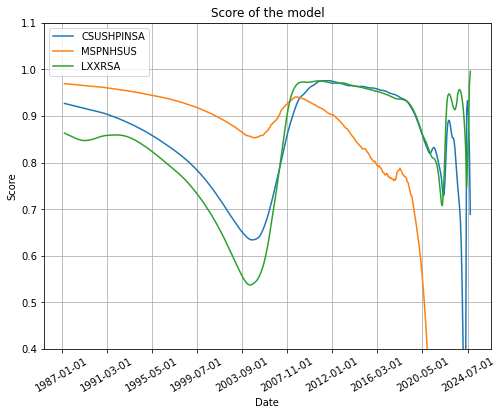

In [32]:
#plot the scores
plt.figure(figsize=(8,6))
for col in columns:
    plt.plot(hpi_scaled['DATE'], hpi_scaled[col + '_score'])
plt.title('Score of the model')
plt.xlabel('Date')
plt.ylabel('Score')
# give more spacing on the x-axis 
plt.xticks(hpi_scaled['DATE'][::50], rotation = 30)
plt.legend(columns)
plt.ylim(0.4, 1.1)
plt.grid()
plt.show()

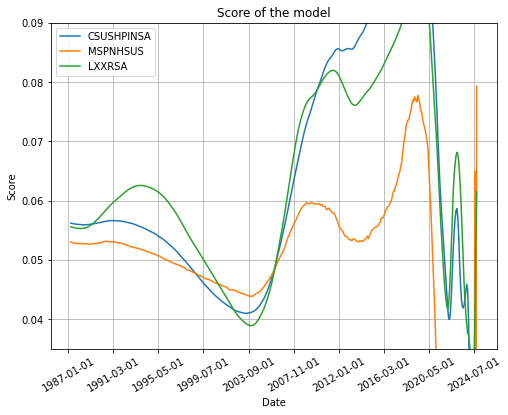

In [33]:
#plot the growth rate
plt.figure(figsize=(8,6))
for col in columns:
    plt.plot(hpi_scaled['DATE'], hpi_scaled[col + '_rate'])
plt.title('Score of the model')
plt.xlabel('Date')
plt.ylabel('Score')
# give more spacing on the x-axis 
plt.xticks(hpi_scaled['DATE'][::50], rotation = 30)
plt.legend(columns)
plt.ylim(0.035, 0.09)
plt.grid()
plt.show()

In [34]:
#filter data
start_date = date(1995, 1, 1)
data = hpi[hpi['DATE'] >= start_date]

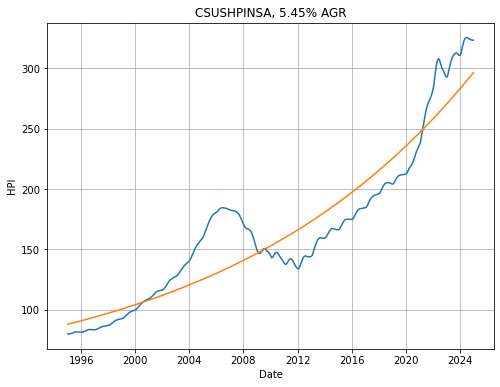

In [35]:
def plot_model(data, hpi_scaled, col):
    # get unscaled predictions
    model = hpi_scaled[hpi_scaled['DATE'] == start_date][f'{col}_model'].values[0]
    # log y = a + b * x
    y_pred_scaled = np.exp(np.polyval(model, data['TIME']))
    y_pred = scalers[col].inverse_transform(y_pred_scaled.reshape(-1, 1))
    r = np.exp(model[0]) - 1
    # plot the data against the model
    plt.figure(figsize=(8,6))
    plt.plot(data['DATE'], data[col])
    plt.plot(data['DATE'], y_pred)
    plt.title(f'{col}, {r*100:.2f}% AGR')
    plt.xlabel('Date')
    plt.ylabel('HPI')
    plt.grid()
    plt.show()

plot_model(data, hpi_scaled, 'CSUSHPINSA')

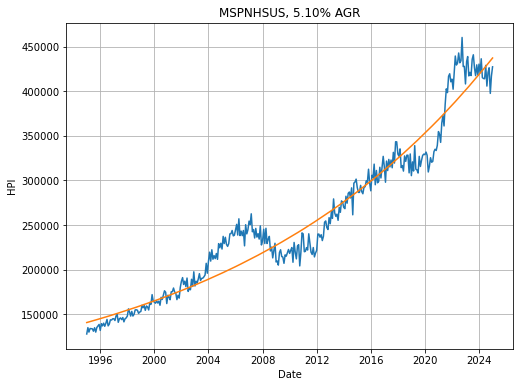

In [36]:
plot_model(data, hpi_scaled, 'MSPNHSUS')

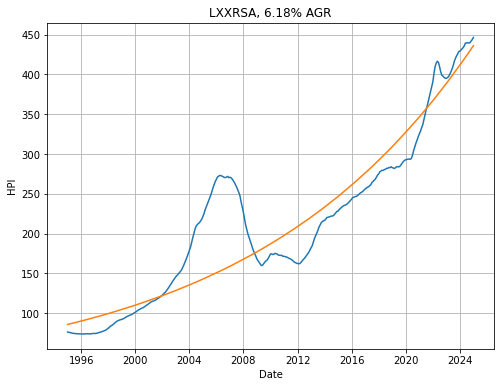

In [37]:
plot_model(data, hpi_scaled, 'LXXRSA')

In [ ]:
zillow = pd.read_excel('ZillowHPI.xlsx')
